In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
import os
from data_fonemas import *
# from data_fonemas import coef_a, coef_b
# from scipy.signal import lfilter
# from data_fonemas import suavizar_bordes, gen_pulsos, coef_a, coef_b


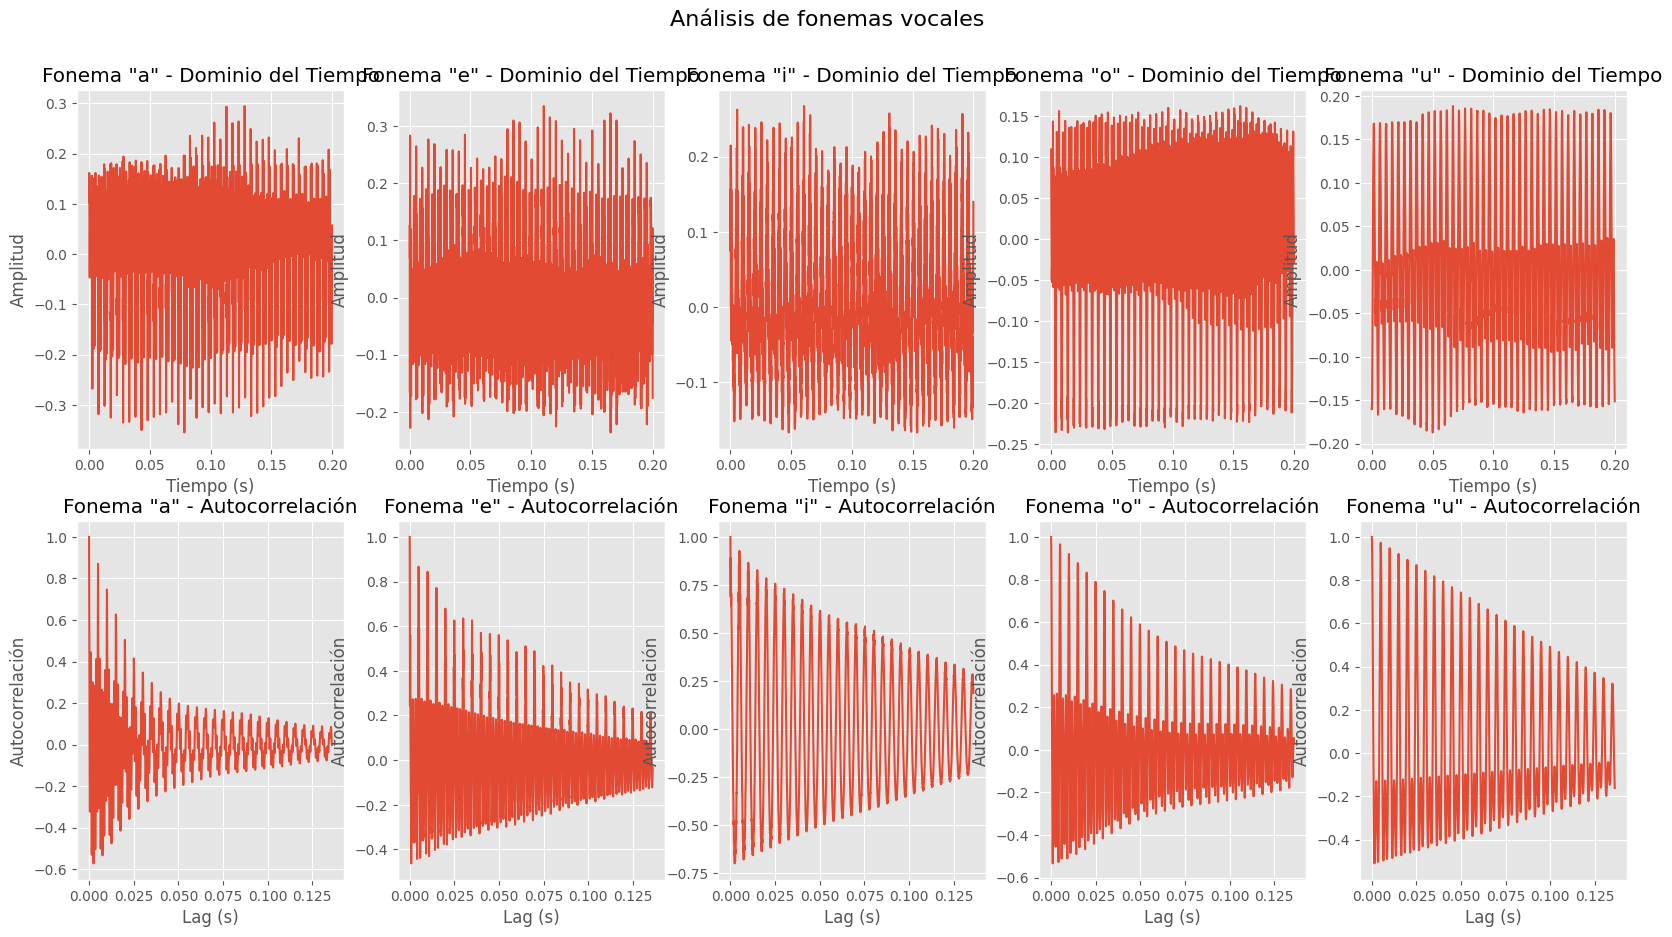

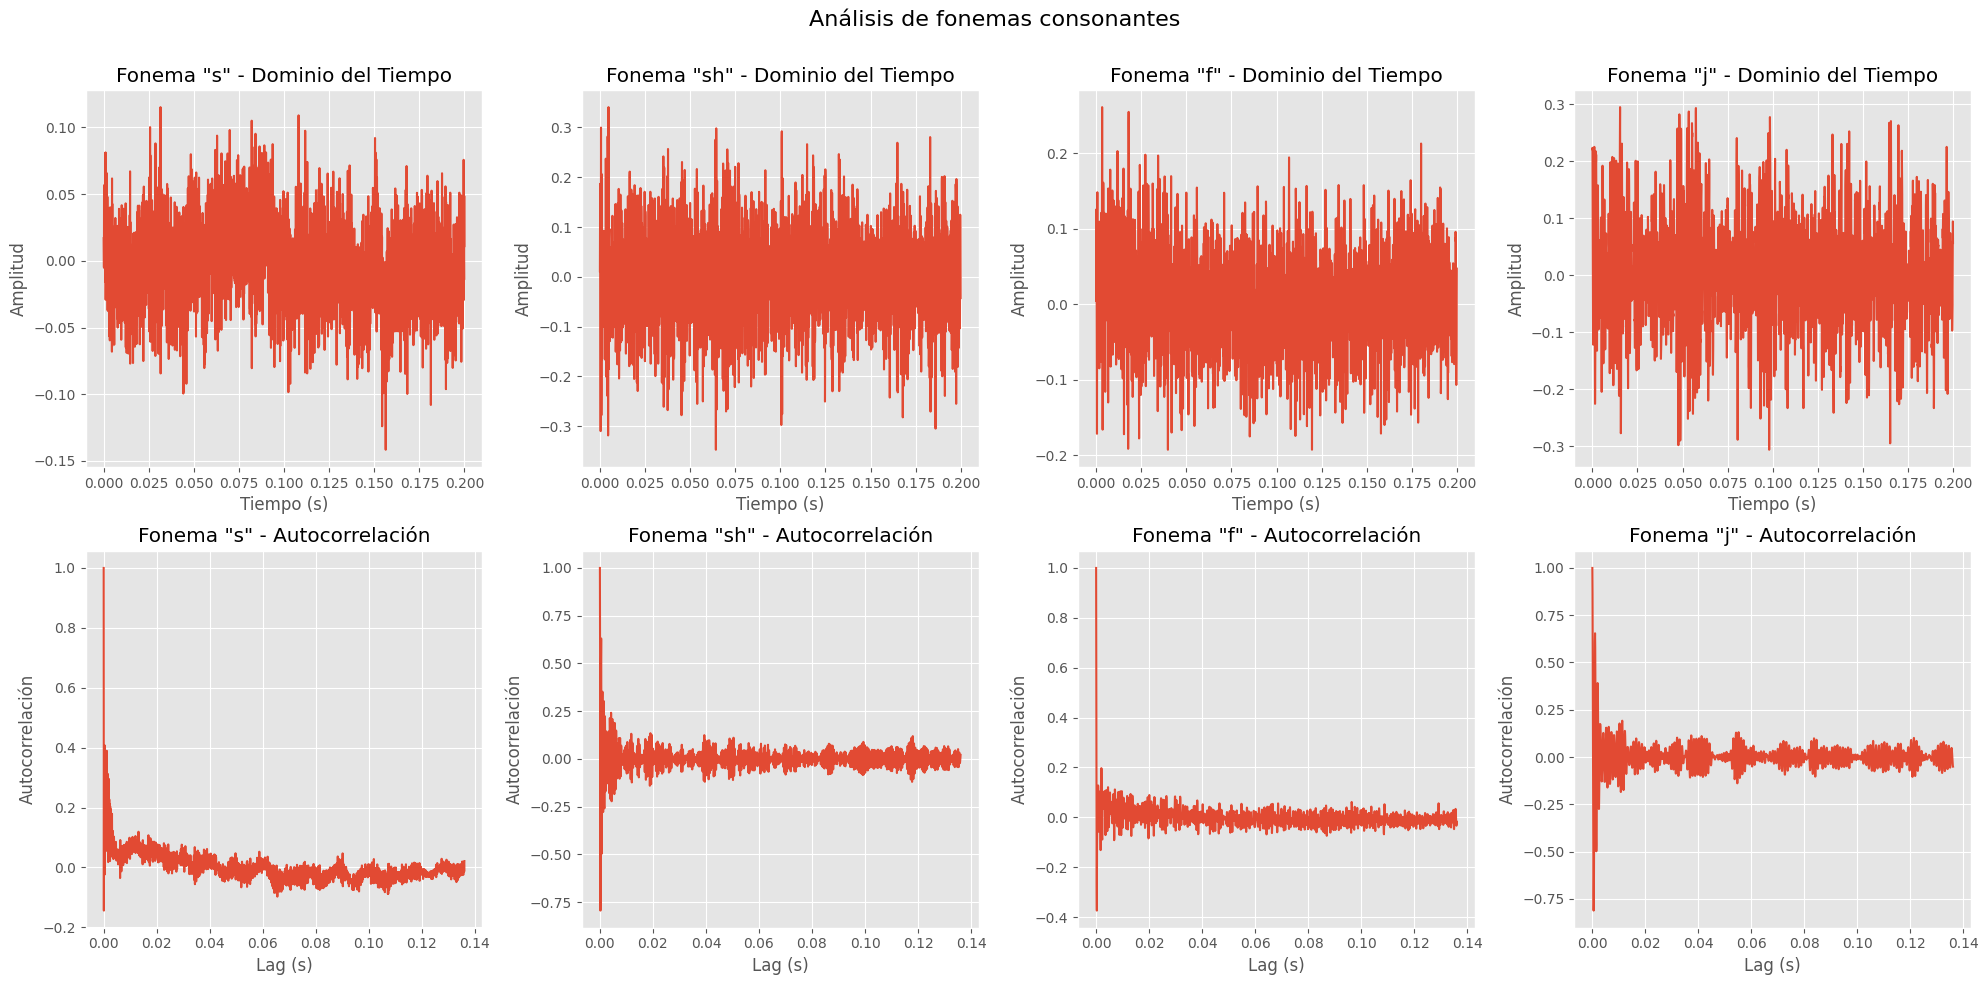

In [4]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

audio_path = "./audios/"

vowels = ['a', 'e', 'i', 'o', 'u']
consonants = ['s', 'sh', 'f', 'j']
fonemas = vowels + consonants

def autocorrelation(x, maxlag=None):
    n = len(x)
    if maxlag is None:
        maxlag = n
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')
    r = r[n-1:n+maxlag]  # Take only positive lags up to maxlag
    return r / r[0]  # Normalize by r[0]

fig_vowels, axs_vowels = plt.subplots(2, len(vowels), figsize=(20, 10))
fig_vowels.suptitle('Análisis de fonemas vocales', fontsize=16)

fig_consonants, axs_consonants = plt.subplots(2, len(consonants), figsize=(20, 10))
fig_consonants.suptitle('Análisis de fonemas consonantes', fontsize=16)

duration = 0.2  # 200ms

for i, fonema in enumerate(fonemas):
    filename = f"{audio_path}{fonema}.wav"
    try:
        audio, fs = sf.read(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue
    
    # Extract 200ms segment from the middle of the audio
    middle = len(audio) // 2
    samples = int(duration * fs)
    segment = audio[middle - samples//2:middle + samples//2]
    
    # Calculate time vector for plotting
    t = np.arange(len(segment)) / fs
    
    # Calculate autocorrelation
    acorr = autocorrelation(segment, maxlag=min(2000, len(segment)))
    lag_time = np.arange(len(acorr)) / fs
    
    if fonema in vowels:
        ax_time = axs_vowels[0, vowels.index(fonema)]
        ax_acorr = axs_vowels[1, vowels.index(fonema)]
    else:
        ax_time = axs_consonants[0, consonants.index(fonema)]
        ax_acorr = axs_consonants[1, consonants.index(fonema)]
    
    ax_time.plot(t, segment)
    ax_time.set_title(f'Fonema "{fonema}" - Dominio del Tiempo')
    ax_time.set_xlabel('Tiempo (s)')
    ax_time.set_ylabel('Amplitud')
    
    ax_acorr.plot(lag_time, acorr)
    ax_acorr.set_title(f'Fonema "{fonema}" - Autocorrelación')
    ax_acorr.set_xlabel('Lag (s)')
    ax_acorr.set_ylabel('Autocorrelación')

plt.tight_layout()
fig_vowels.subplots_adjust(top=0.9)
fig_consonants.subplots_adjust(top=0.9)
plt.show()

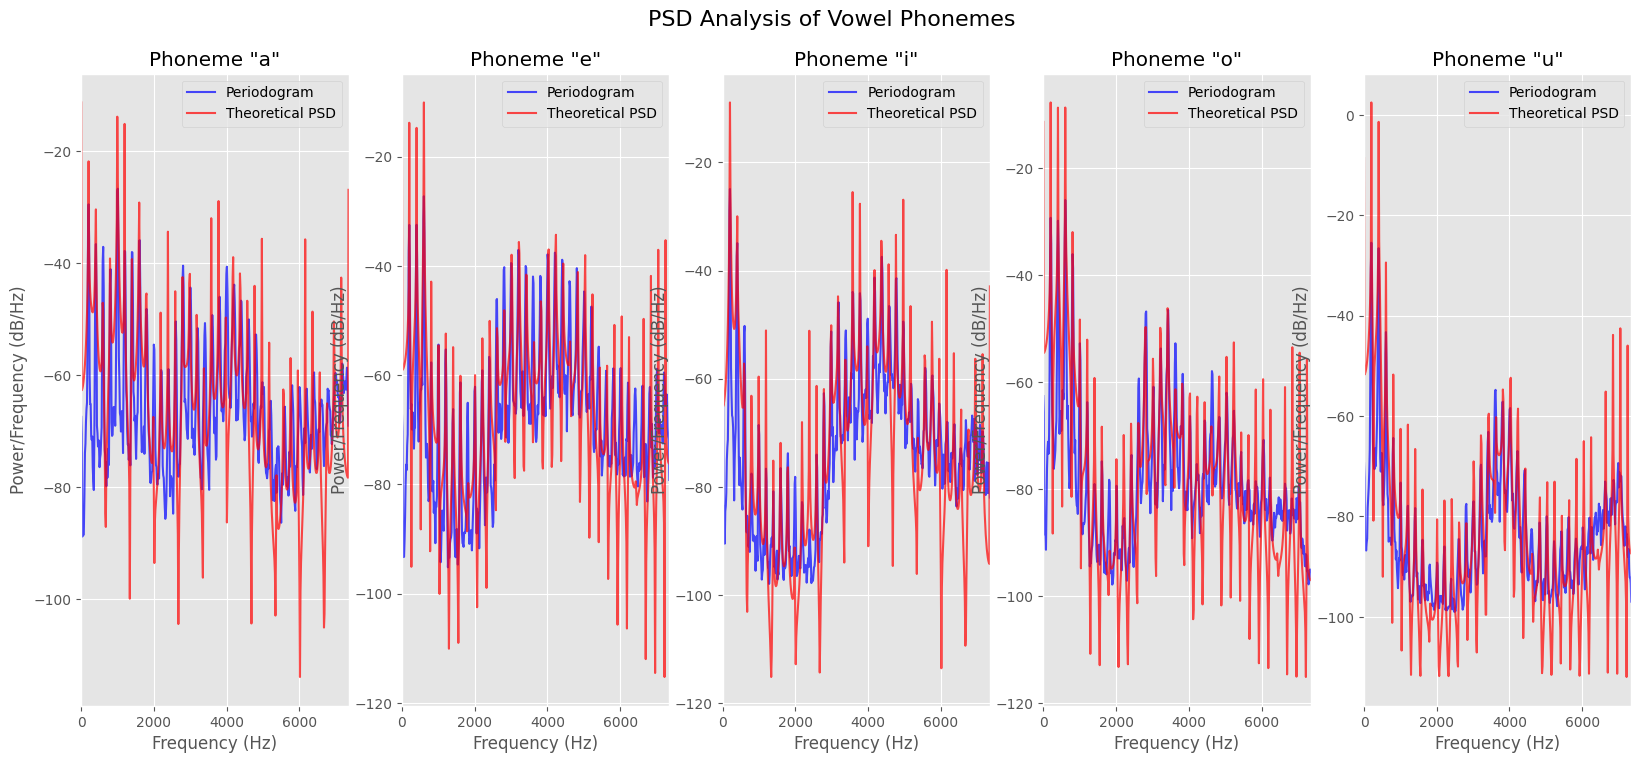

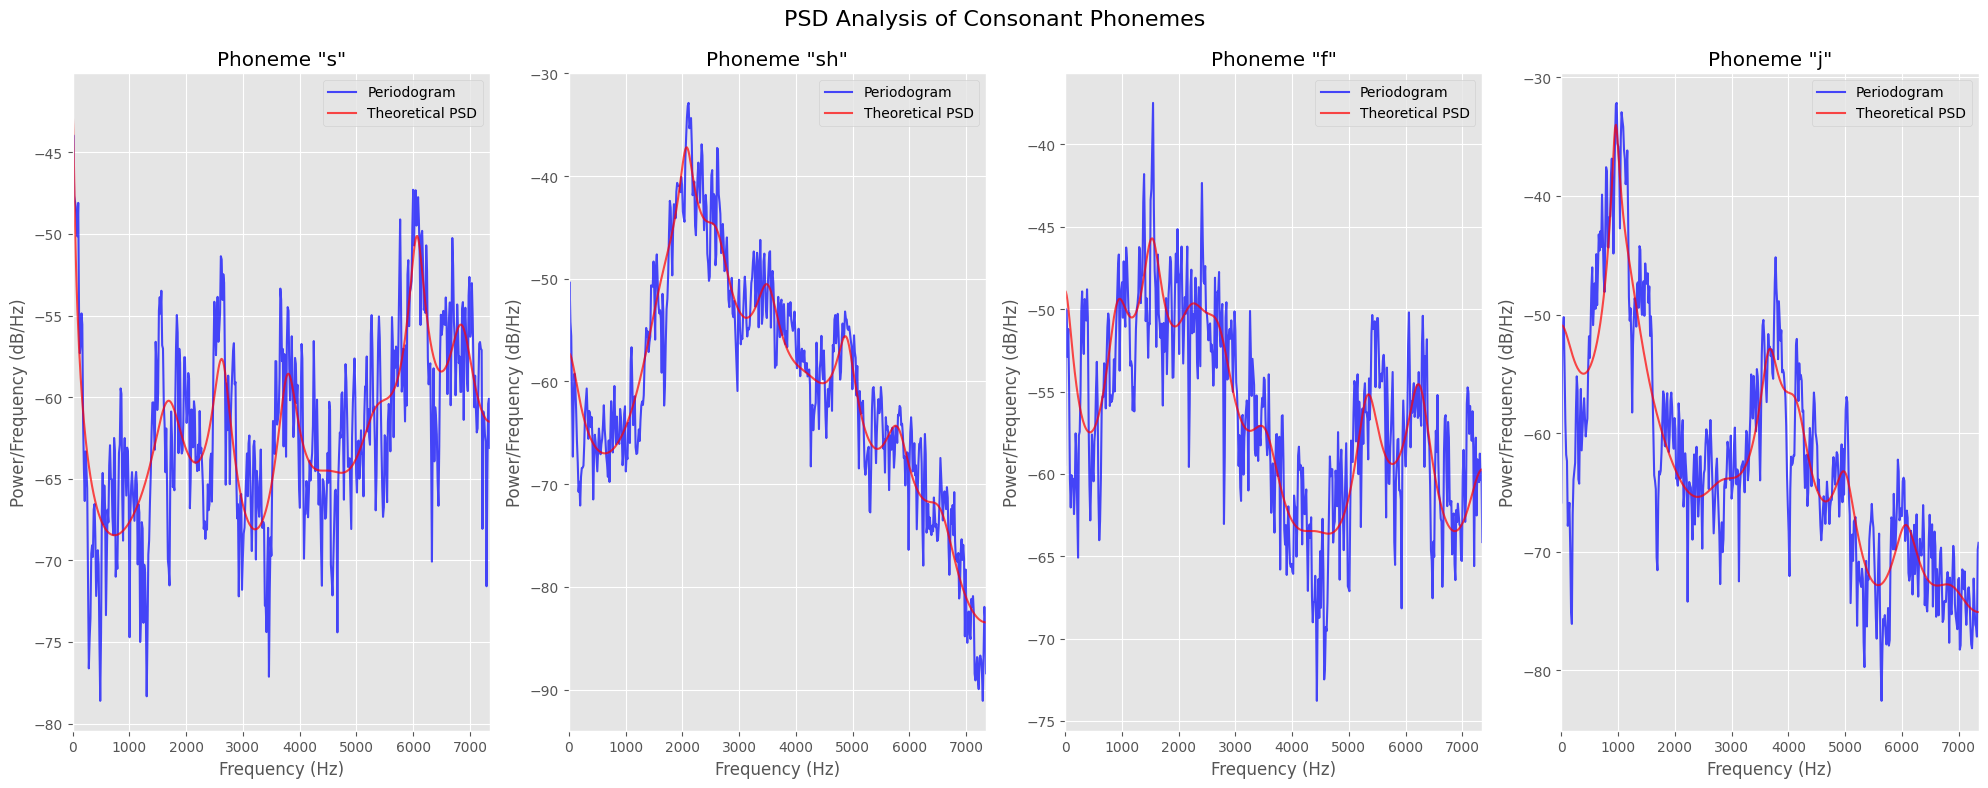

In [5]:
fs = 14700

# Update the theoretical_psd function to fix the deprecation warning
def theoretical_psd(a_coef, b_coef, f, fs, phoneme_type='consonant', pitch=None):
    """
    Calculate theoretical PSD for an AR model according to equation (3)
    a_coef: array of AR coefficients 
    b_coef: gain coefficient (passed as a list [value])
    f: frequency points for calculation (Hz)
    fs: sampling frequency (Hz)
    phoneme_type: 'consonant' (white noise excitation) or 'vowel' (periodic impulses)
    pitch: fundamental frequency for vowel sounds (Hz)
    """
    w = 2 * np.pi * f / fs  # Convert frequency to digital frequency
    
    # Extract the scalar value from b_coef which is a list
    b_scalar = b_coef[0]  # Fixed: Extract scalar value from list
    
    # Calculate frequency response H(ω)
    z = np.exp(-1j * w)
    H = np.zeros_like(f, dtype=complex)
    for i in range(len(f)):
        denominator = 1
        for j, a in enumerate(a_coef):
            denominator -= a * z[i]**(j+1)
        H[i] = b_scalar / denominator  # Fixed: Use scalar value 
    
    # Rest of function remains unchanged
    if phoneme_type == 'consonant':
        # White noise excitation, S_U(f) = 1
        S_X = np.abs(H)**2
    else:  # vowel
        # Periodic excitation
        # The psd_pulsos function takes (pitch, N, fs) and returns (PSD, freqs)
        N = 8192  # Use a power of 2 for efficient FFT
        
        # Get the PSD of the pulse train and its corresponding frequencies
        pulse_psd, pulse_freqs = psd_pulsos(pitch, N, fs)
        
        # Interpolate the pulse PSD to match our frequency points
        from scipy.interpolate import interp1d
        
        # Create interpolation function
        interp_func = interp1d(
            pulse_freqs, 
            pulse_psd, 
            kind='linear', 
            bounds_error=False, 
            fill_value=0
        )
        
        # Apply interpolation to get PSD values at our frequency points
        S_U = interp_func(f)
        
        # Calculate final PSD
        S_X = np.abs(H)**2 * S_U
        
    return S_X

# Create plot for vowels and consonants
fig_psd_vowels, axs_psd_vowels = plt.subplots(1, len(vowels), figsize=(20, 8))
fig_psd_vowels.suptitle('PSD Analysis of Vowel Phonemes', fontsize=16)

fig_psd_consonants, axs_psd_consonants = plt.subplots(1, len(consonants), figsize=(20, 8))
fig_psd_consonants.suptitle('PSD Analysis of Consonant Phonemes', fontsize=16)

duration = 0.2  # 200ms

# Process each phoneme
for phoneme in fonemas:
    filename = f"{audio_path}{phoneme}.wav"
    try:
        audio, fs = sf.read(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue
    
    # Extract 200ms segment from the middle of the audio
    middle = len(audio) // 2
    samples = int(duration * fs)
    segment = audio[middle - samples//2:middle + samples//2]
    
    # Apply Hanning window to reduce spectral leakage
    window = np.hanning(len(segment))
    windowed_segment = segment * window
    
    # Calculate periodogram using Welch's method
    f_welch, Pxx_welch = signal.welch(windowed_segment, fs=fs, nperseg=1024, 
                                     noverlap=512, scaling='spectrum')
    
    # Convert to dB for better visualization
    Pxx_db = 10 * np.log10(Pxx_welch + 1e-10)  # Add small value to avoid log(0)
    
    # Get the AR coefficients for this phoneme
    a_coefs = coef_a[phoneme]
    b_coef = coef_b[phoneme]
    
    # Calculate theoretical PSD
    if phoneme in vowels:
        # For vowels, we need to estimate the pitch (fundamental frequency)
        # This can be estimated from the autocorrelation
        acorr = autocorrelation(segment, maxlag=min(2000, len(segment)))
        # Find the first peak after the zero lag (which is always 1)
        # Exclude the first few samples to avoid detecting the main lobe
        exclude_samples = 20
        peak_idx = exclude_samples + np.argmax(acorr[exclude_samples:min(1000, len(acorr))])
        estimated_pitch = fs / peak_idx if peak_idx > 0 else 100  # Default to 100Hz if no clear peak
        
        # Calculate theoretical PSD with periodic excitation
        S_X_theory = theoretical_psd(a_coefs, b_coef, f_welch, fs, 
                                    phoneme_type='vowel', pitch=estimated_pitch)
    else:
        # For consonants, use white noise excitation
        S_X_theory = theoretical_psd(a_coefs, b_coef, f_welch, fs, 
                                    phoneme_type='consonant')
    
    # Convert theoretical PSD to dB
    S_X_theory_db = 10 * np.log10(S_X_theory + 1e-10)
    
    # Adjust scale factor to match the empirical and theoretical PSD levels
    scale_factor = np.mean(Pxx_db) - np.mean(S_X_theory_db)
    S_X_theory_db += scale_factor
    
    # Select the appropriate axis based on phoneme type
    if phoneme in vowels:
        ax = axs_psd_vowels[vowels.index(phoneme)]
    else:
        ax = axs_psd_consonants[consonants.index(phoneme)]
    
    # Plot both the periodogram and theoretical PSD
    ax.plot(f_welch, Pxx_db, 'b-', alpha=0.7, label='Periodogram')
    ax.plot(f_welch, S_X_theory_db, 'r-', alpha=0.7, label='Theoretical PSD')
    
    # Only display frequencies up to Nyquist (fs/2)
    ax.set_xlim(0, fs/2)
    
    # Set labels and title
    ax.set_title(f'Phoneme "{phoneme}"')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
fig_psd_vowels.subplots_adjust(top=0.9)
fig_psd_consonants.subplots_adjust(top=0.9)

# Show the figures
plt.show()

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


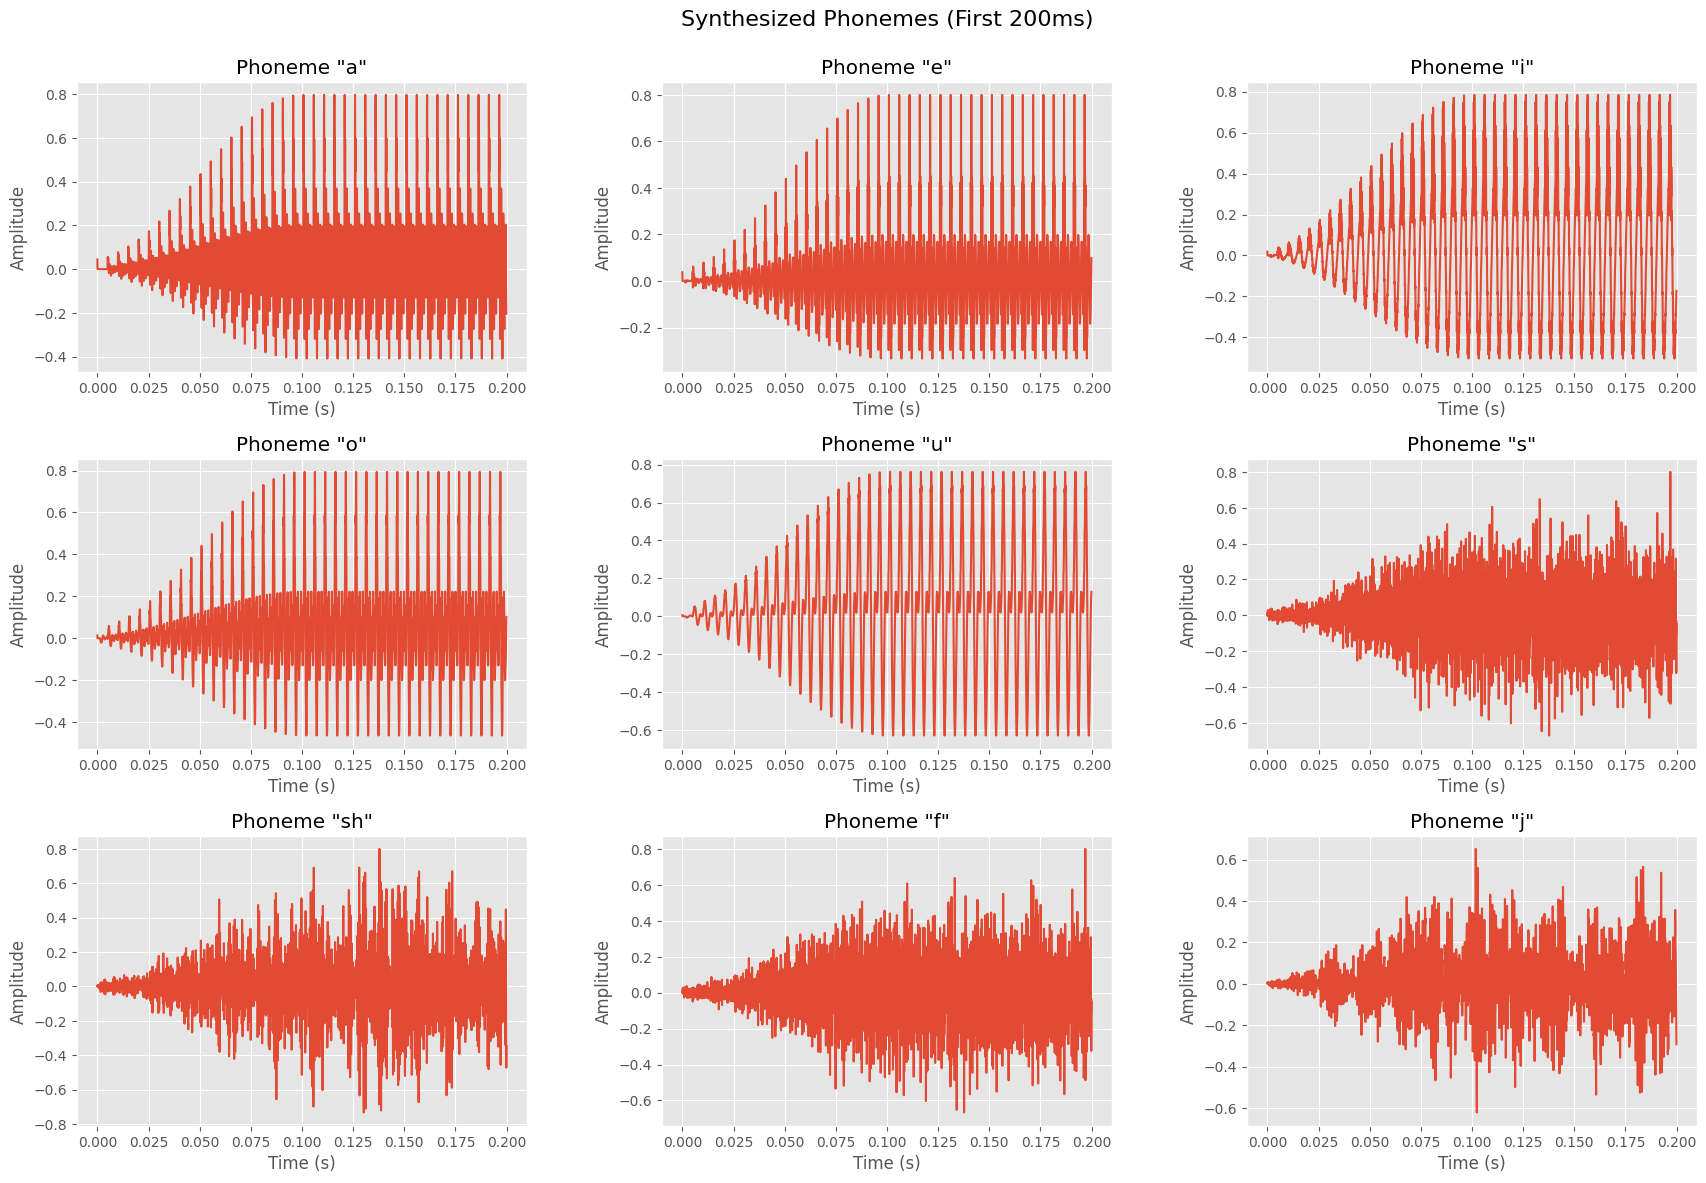

In [6]:
# Phoneme Synthesis - Exercise 2 with fixed 's' and 'f' synthesis
fs = 14700  # Sampling frequency (Hz)
duration = 0.5  # 500 ms
N = int(fs * duration)  # Number of samples
f0 = 200  # Fundamental frequency for vowels (Hz)

# Dictionary to store synthesized phonemes
synthesized_phonemes = {}

# Create a figure to plot the synthesized phonemes
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized Phonemes (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all phonemes
for i, phoneme in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for phoneme {phoneme}")
        continue
        
    # Get AR coefficients
    a_coeffs = coef_a[phoneme]
    b_coeff = coef_b[phoneme][0]  # Extract scalar value from list
    
    # Create excitation signal based on phoneme type
    if phoneme in vowels:
        # For vowels: use pulse train
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonants: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special handling for problematic phonemes 's' and 'f'
    if phoneme in ['s', 'f']:
        # Use a modified approach for these unstable phonemes
        try:
            # Get spectral envelope from coefficients (evaluate at frequency points)
            nfft = 512
            w, h = signal.freqz([b_coeff], [1.0] + a_coeffs, worN=nfft)
            
            # Create a new noise signal
            np.random.seed(42)  # For reproducibility
            noise = np.random.randn(N)
            
            # Apply spectral shaping in frequency domain
            noise_fft = np.fft.rfft(noise)
            freq_bins = min(len(noise_fft), nfft//2+1)
            
            # Interpolate the frequency response to match FFT bins
            from scipy.interpolate import interp1d
            f_normalized = w / np.pi
            mag_response = np.abs(h)
            
            # Ensure we have valid values
            valid_indices = ~np.isnan(mag_response) & ~np.isinf(mag_response)
            if np.sum(valid_indices) > 1:
                f_valid = f_normalized[valid_indices]
                mag_valid = mag_response[valid_indices]
                
                # Create interpolation function (with bounds checking)
                interp_func = interp1d(
                    f_valid, mag_valid, 
                    bounds_error=False, 
                    fill_value=(mag_valid[0], mag_valid[-1])
                )
                
                # Generate target frequency points (0 to 1)
                target_freqs = np.linspace(0, 1, freq_bins)
                
                # Get filter shape at those frequencies
                filter_shape = interp_func(target_freqs)
                
                # Apply filter shape to noise spectrum (with safety checks)
                filter_shape = np.clip(filter_shape, 0, 10)  # Prevent extreme values
                noise_fft[:freq_bins] *= filter_shape
                
                # Convert back to time domain
                synthesized = np.fft.irfft(noise_fft, n=N)
            else:
                # Fallback if interpolation fails
                synthesized = signal.lfilter([b_coeff], [1.0], noise)
                
            # Normalize the result
            synthesized = synthesized / (np.max(np.abs(synthesized)) + 1e-10) * 0.8
            
        except Exception as e:
            print(f"Error in spectral approach for {phoneme}, using simpler alternative: {str(e)}")
            # Even simpler fallback: band-pass filtered noise
            if phoneme == 's':
                # 's' is typically higher frequency (4000-8000 Hz)
                synthesized = signal.butter_bandpass_filter(excitation, 4000, 8000, fs, order=4)
            else:  # 'f'
                # 'f' has energy in mid-high frequencies (2000-6000 Hz)
                synthesized = signal.butter_bandpass_filter(excitation, 2000, 6000, fs, order=4)
            
            # Normalize
            synthesized = synthesized / (np.max(np.abs(synthesized)) + 1e-10) * 0.8
    else:
        # Use the original approach for other phonemes
        try:
            # Apply AR model using filter with stability protection
            a_full = np.concatenate(([1.0], a_coeffs))
            synthesized = signal.lfilter([b_coeff], a_full, excitation)
            
            # Check for instability or overflow
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {phoneme}, using alternative approach")
                
                # Alternative approach: apply filter manually with stability protection
                synthesized = np.zeros(N)
                # Set initial values
                for n in range(min(20, N)):
                    synthesized[n] = b_coeff * excitation[n]
                
                # Apply recursive filter with amplitude limiting
                for n in range(20, N):
                    synthesized[n] = b_coeff * excitation[n]
                    for j, a in enumerate(a_coeffs):
                        if n-j-1 >= 0:  # Ensure we don't go out of bounds
                            synthesized[n] += a * synthesized[n-j-1]
                    # Limit extreme values
                    synthesized[n] = np.clip(synthesized[n], -100, 100)
            
            # Normalize the signal
            if np.max(np.abs(synthesized)) > 0:
                synthesized = 0.8 * synthesized / np.max(np.abs(synthesized))
                
        except Exception as e:
            print(f"Error processing phoneme {phoneme}: {str(e)}")
            synthesized = np.zeros(N)
            
    # Smooth the edges with 20% transition (for all phonemes)
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized phoneme
    synthesized_phonemes[phoneme] = synthesized
    
    # Check for valid data before plotting
    if not np.all(np.isfinite(synthesized[:int(0.2*fs)])):
        print(f"Warning: Invalid data in synthesized {phoneme}, cleaning before plotting")
        plotting_data = np.nan_to_num(synthesized[:int(0.2*fs)], nan=0.0, posinf=0.0, neginf=0.0)
        plotting_data = np.clip(plotting_data, -1, 1)  # Ensure reasonable plot range
    else:
        plotting_data = synthesized[:int(0.2*fs)]
        
    # Display first 200ms of synthesized phoneme
    display_samples = int(0.2 * fs)  # 200ms of samples
    t = np.arange(display_samples) / fs  # Time vector for first 200ms
    
    axs[i].plot(t, plotting_data)
    axs[i].set_title(f'Phoneme "{phoneme}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout safely without tight_layout
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized phonemes to wav files
output_dir = "./synthesized/"
os.makedirs(output_dir, exist_ok=True)

for phoneme, audio in synthesized_phonemes.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0, posinf=0.0, neginf=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)  # Prevent clipping in audio
    sf.write(f"{output_dir}{phoneme}_synth.wav", valid_audio, fs)

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


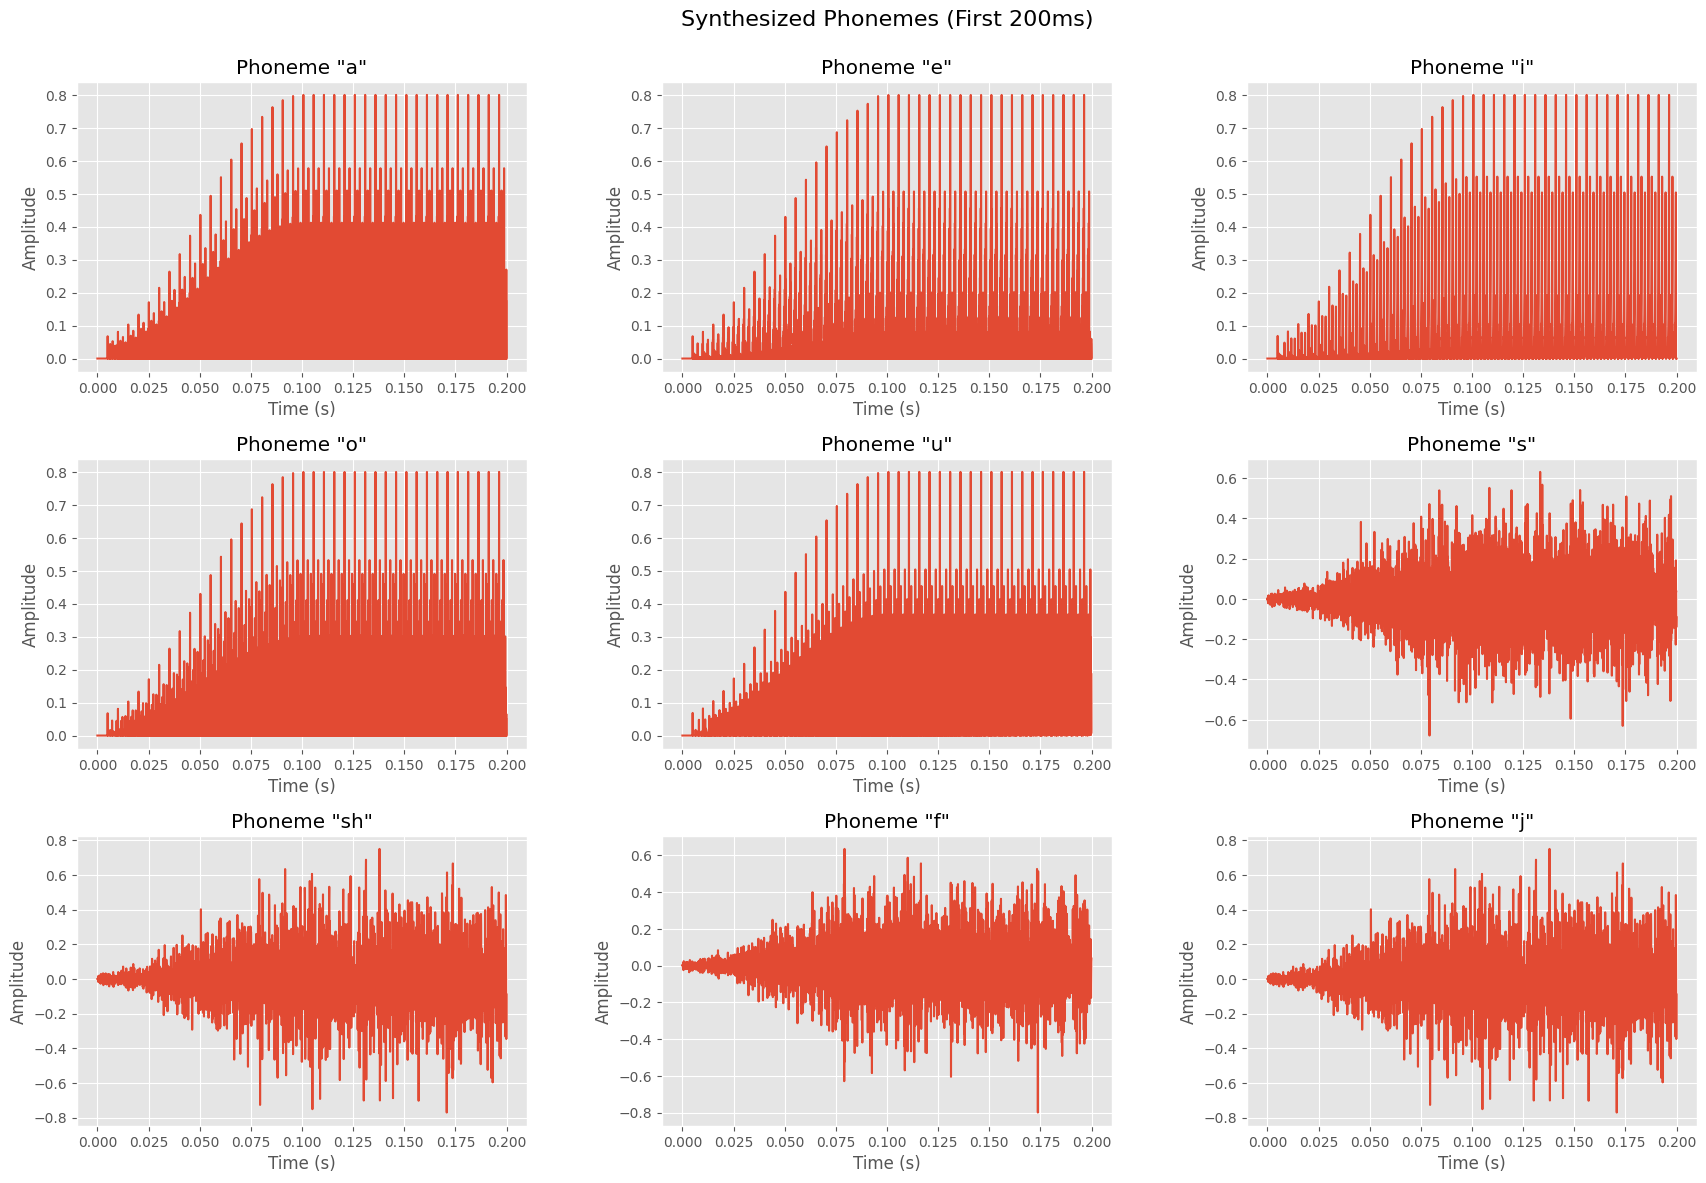

In [9]:
# Simplified implementation for Exercise 2 - Phoneme Synthesis
fs = 14700  # Sampling frequency (Hz)
duration = 0.5  # 500 ms
N = int(fs * duration)  # Number of samples
f0 = 200  # Fundamental frequency for vowels (Hz)

# Corrected version of the bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter with safety checks for Nyquist limit"""
    nyquist = 0.5 * fs
    
    # Ensure cutoff frequencies don't exceed Nyquist
    lowcut = min(lowcut, 0.98 * nyquist)
    highcut = min(highcut, 0.98 * nyquist)
    
    # Normalize frequencies to [0, 1] range
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Ensure we have proper ordering
    if high <= low:
        high = min(0.98, low + 0.1)
    
    # Create and apply filter
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y
# Dictionary to store synthesized phonemes
synthesized_phonemes = {}

# Create a figure to plot the synthesized phonemes
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized Phonemes (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all phonemes
for i, phoneme in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for phoneme {phoneme}")
        continue
        
    # Get AR coefficients
    a_coeffs = coef_a[phoneme]
    b_coeff = coef_b[phoneme][0]  # Extract scalar value from list
    
    # Create excitation signal based on phoneme type
    if phoneme in vowels:
        # For vowels: use pulse train
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonants: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special direct handling for 's' and 'f' phonemes
    if phoneme == 's':
        # For 's': use filtered noise in high frequency range (stay below Nyquist)
        synthesized = butter_bandpass_filter(excitation, 3500, 7000, fs)
        # Add some lower frequency energy for better character
        mid_freq_component = butter_bandpass_filter(excitation, 1500, 3000, fs) * 0.3
        synthesized += mid_freq_component
    elif phoneme == 'f':
        # For 'f': use filtered noise with broader spectrum (stay below Nyquist)
        synthesized = butter_bandpass_filter(excitation, 1500, 6000, fs)
        # Add specific formants to give 'f' character
        formant1 = butter_bandpass_filter(excitation, 1000, 1500, fs) * 0.6
        formant2 = butter_bandpass_filter(excitation, 3000, 5000, fs) * 0.7
        synthesized = 0.5*synthesized + formant1 + formant2
    else:
        # For all other phonemes, use standard AR filtering
        try:
            # Apply AR model using filter
            a_full = np.concatenate(([1.0], a_coeffs))
            synthesized = signal.lfilter([b_coeff], a_full, excitation)
            
            # Check for instability
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {phoneme}, using alternative approach")
                # Create a simplified version using formant filtering
                if phoneme in vowels:
                    # Apply formant filters based on vowel characteristics
                    f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[phoneme]
                    f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[phoneme]
                    
                    # Create formant filters
                    bw1 = f1 * 0.1  # 10% bandwidth
                    bw2 = f2 * 0.1
                    
                    # Apply resonances to pulse train
                    synthesized = signal.lfilter([1.0], [1.0, -0.9], excitation)  # Pre-emphasis
                    
                    # Simple formant synthesis with basic resonators
                    q1 = int(fs / f1)  # Simple comb filter approach
                    q2 = int(fs / f2)
                    
                    resonator1 = np.zeros(N)
                    resonator2 = np.zeros(N)
                    
                    # Apply resonances
                    for n in range(q1, N):
                        resonator1[n] = 0.9 * resonator1[n-q1] + excitation[n]
                        
                    for n in range(q2, N):
                        resonator2[n] = 0.8 * resonator2[n-q2] + excitation[n]
                        
                    synthesized = 0.7 * resonator1 + 0.3 * resonator2
                else:
                    # For unstable consonants, use filtered noise
                    synthesized = butter_bandpass_filter(excitation, 1000, 4000, fs)
        except Exception as e:
            print(f"Error processing {phoneme}: {str(e)}")
            synthesized = np.zeros(N)  # Fallback to silence
    
    # Normalize to reasonable amplitude
    max_amp = np.max(np.abs(synthesized))
    if max_amp > 0:
        synthesized = 0.8 * synthesized / max_amp
    
    # Apply edge smoothing with 20% transition
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized phoneme
    synthesized_phonemes[phoneme] = synthesized
    
    # Display first 200ms
    display_samples = int(0.2 * fs)
    t = np.arange(display_samples) / fs
    
    # Clean any remaining invalid values
    plotting_data = np.nan_to_num(synthesized[:display_samples], nan=0.0)
    plotting_data = np.clip(plotting_data, -1, 1)
    
    # Plot the phoneme
    axs[i].plot(t, plotting_data)
    axs[i].set_title(f'Phoneme "{phoneme}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout and display
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized phonemes to audio files
output_dir = "./sintetizado_2/"
os.makedirs(output_dir, exist_ok=True)

for phoneme, audio in synthesized_phonemes.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}{phoneme}_synth.wav", valid_audio, fs)

Concatenating phonemes in the following order:
1. a
2. e
3. i
4. o
5. u
6. s
7. sh
8. f
9. j


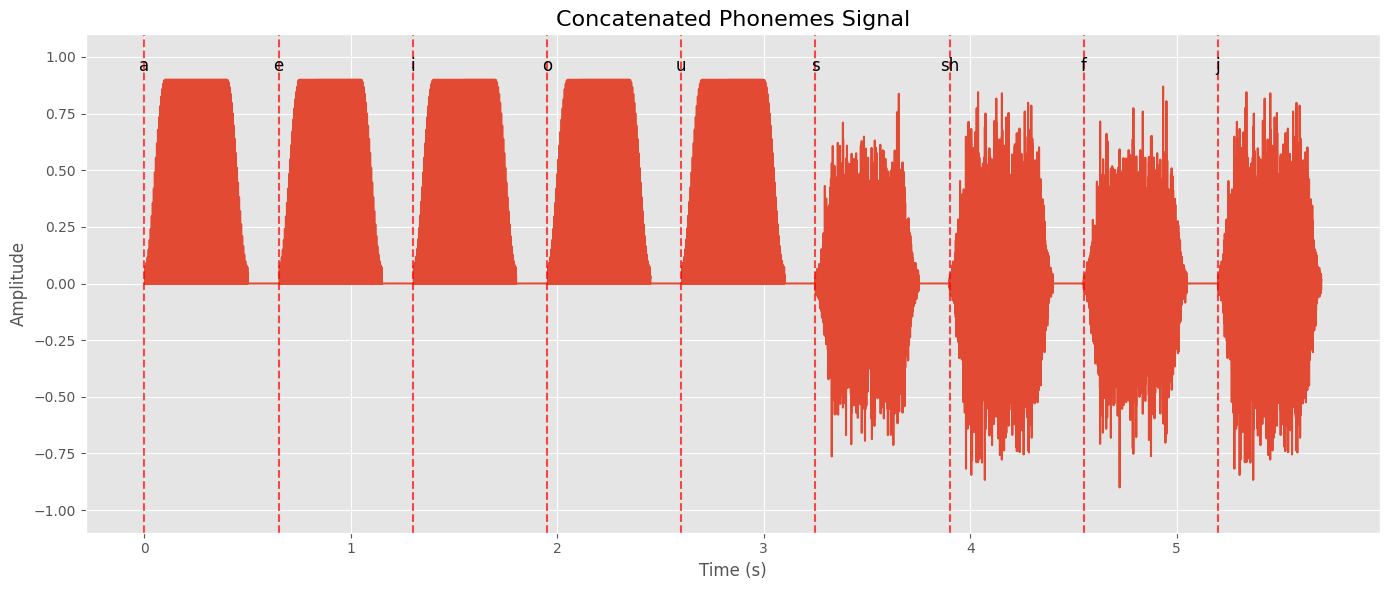

Playing concatenated phonemes:


In [10]:
# Exercise 2(b): Concatenate all phonemes into a single signal for evaluation
fs = 14700  # Sampling frequency (Hz)

# Define the order for concatenating phonemes (vowels then consonants)
phoneme_sequence = vowels + consonants  # ['a', 'e', 'i', 'o', 'u', 's', 'sh', 'f', 'j']

# Create a short silence (150ms) to insert between phonemes
silence_duration = 0.15  # 150ms
silence = np.zeros(int(silence_duration * fs))

# Concatenate all phonemes with silence in between
concatenated_signal = []

print("Concatenating phonemes in the following order:")
for i, phoneme in enumerate(phoneme_sequence):
    print(f"{i+1}. {phoneme}")
    
    # Get the phoneme audio (ensuring it has valid values)
    phoneme_audio = synthesized_phonemes[phoneme]
    valid_audio = np.nan_to_num(phoneme_audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    
    # Add phoneme to the concatenated signal
    concatenated_signal.extend(valid_audio)
    
    # Add silence after each phoneme (except the last one)
    if i < len(phoneme_sequence) - 1:
        concatenated_signal.extend(silence)

# Convert to numpy array
concatenated_signal = np.array(concatenated_signal)

# Normalize the final signal
max_amp = np.max(np.abs(concatenated_signal))
if max_amp > 0:
    concatenated_signal = 0.9 * concatenated_signal / max_amp

# Create a time vector for plotting
t = np.arange(len(concatenated_signal)) / fs

# Plot the concatenated signal
plt.figure(figsize=(14, 6))
plt.plot(t, concatenated_signal)

# Add vertical lines and labels to mark where each phoneme begins
current_pos = 0
for i, phoneme in enumerate(phoneme_sequence):
    phoneme_start = current_pos / fs
    plt.axvline(x=phoneme_start, color='r', linestyle='--', alpha=0.7)
    plt.text(phoneme_start, 1.0, phoneme, fontsize=12, 
             horizontalalignment='center', verticalalignment='top')
    
    # Update position for next phoneme
    current_pos += len(synthesized_phonemes[phoneme])
    if i < len(phoneme_sequence) - 1:
        current_pos += len(silence)

plt.title('Concatenated Phonemes Signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(-1.1, 1.1)  # Give space for phoneme labels
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the concatenated signal to a wav file
concatenated_filename = f"{output_dir}concatenated_phonemes.wav"
sf.write(concatenated_filename, concatenated_signal, fs)

# Play the concatenated signal (if in Jupyter notebook)
try:
    from IPython.display import Audio, display
    print("Playing concatenated phonemes:")
    display(Audio(concatenated_signal, rate=fs))
except ImportError:
    print(f"Concatenated phonemes saved to: {concatenated_filename}")
    print("Use an audio player to listen to the file for subjective evaluation.")

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


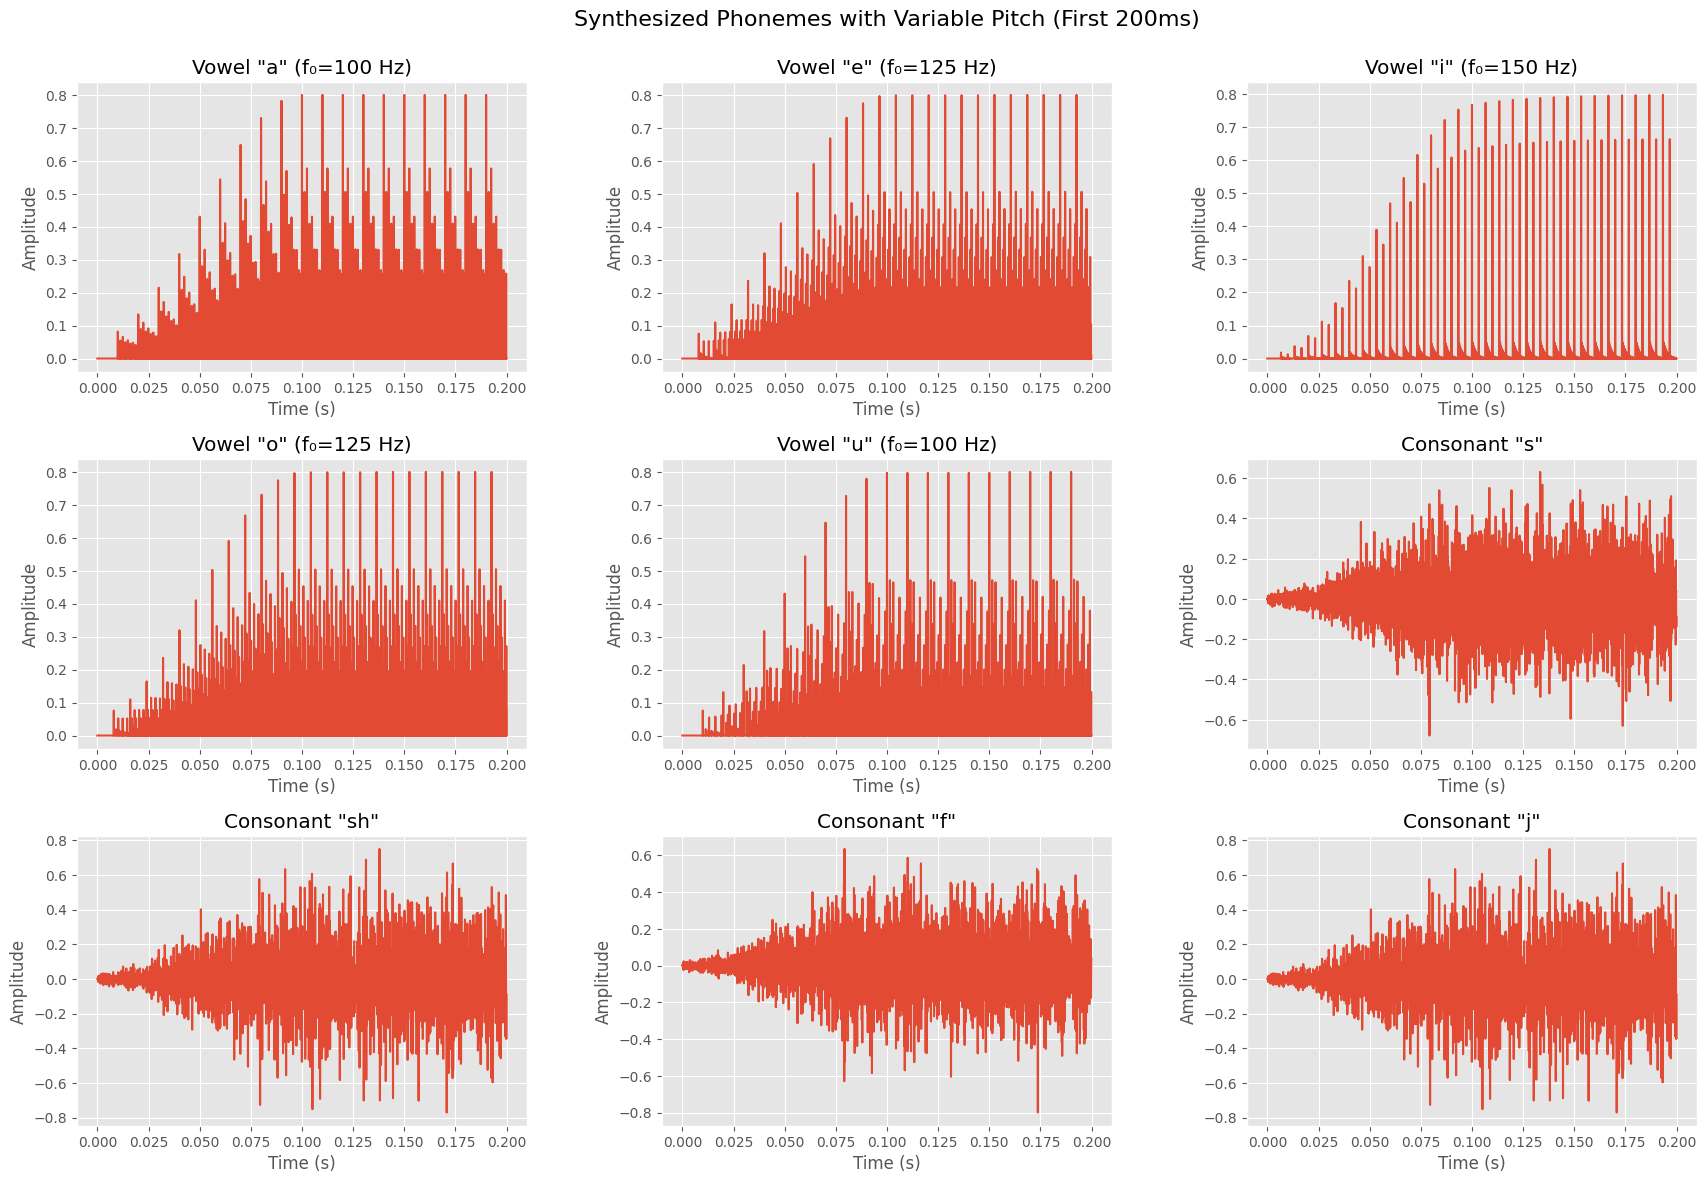

Concatenating phonemes with variable pitch in the following order:
1. a (f₀=100 Hz)
2. e (f₀=125 Hz)
3. i (f₀=150 Hz)
4. o (f₀=125 Hz)
5. u (f₀=100 Hz)
6. s
7. sh
8. f
9. j


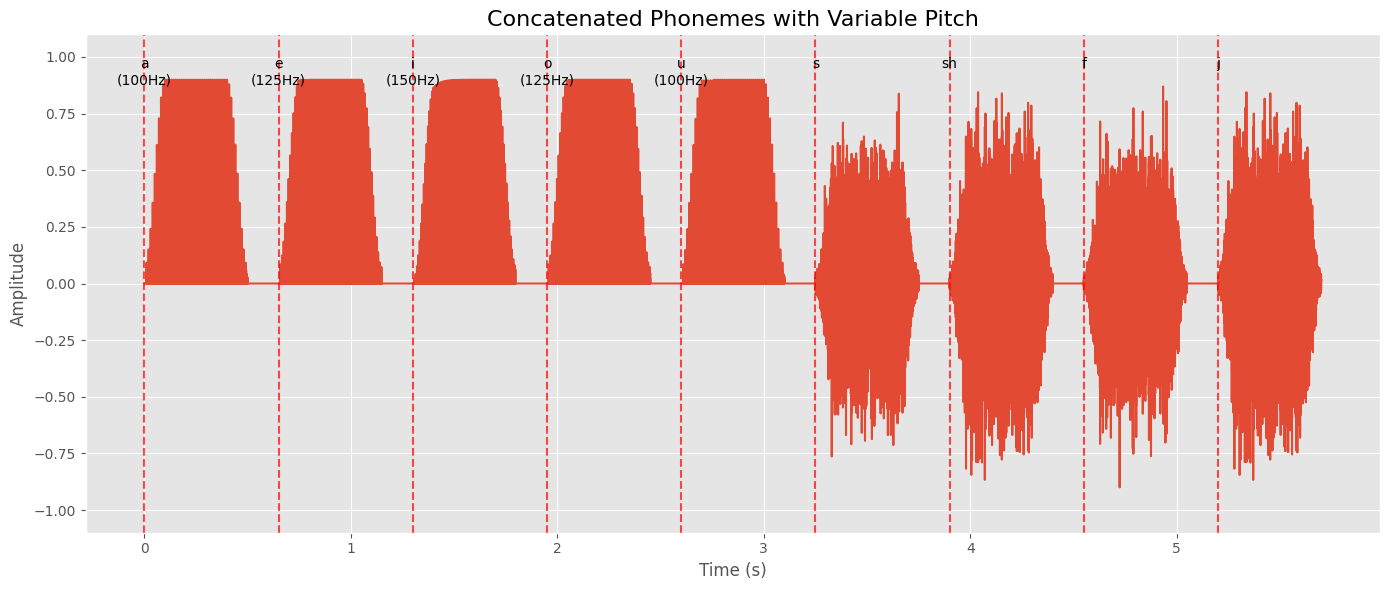

Playing concatenated phonemes with variable pitch:


In [11]:
# Exercise 2(c): Synthesize phonemes with different pitch for each vowel
fs = 14700  # Sampling frequency (Hz)
duration = 0.5  # 500 ms
N = int(fs * duration)  # Number of samples

# Define different pitch frequencies for vowels as specified
pitch_values = {
    'a': 100,  # 100 Hz
    'e': 125,  # 125 Hz
    'i': 150,  # 150 Hz
    'o': 125,  # 125 Hz
    'u': 100   # 100 Hz
}

# Corrected bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter with safety checks for Nyquist limit"""
    nyquist = 0.5 * fs
    
    # Ensure cutoff frequencies don't exceed Nyquist
    lowcut = min(lowcut, 0.98 * nyquist)
    highcut = min(highcut, 0.98 * nyquist)
    
    # Normalize frequencies to [0, 1] range
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Ensure we have proper ordering
    if high <= low:
        high = min(0.98, low + 0.1)
    
    # Create and apply filter
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y

# Dictionary to store synthesized phonemes
synthesized_phonemes = {}

# Create a figure to plot the synthesized phonemes
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized Phonemes with Variable Pitch (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all phonemes
for i, phoneme in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for phoneme {phoneme}")
        continue
        
    # Get AR coefficients
    a_coeffs = coef_a[phoneme]
    b_coeff = coef_b[phoneme][0]  # Extract scalar value from list
    
    # Create excitation signal based on phoneme type
    if phoneme in vowels:
        # For vowels: use pulse train with the specific pitch for this vowel
        f0 = pitch_values[phoneme]  # Get specific pitch for this vowel
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonants: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special direct handling for 's' and 'f' phonemes
    if phoneme == 's':
        # For 's': use filtered noise in high frequency range
        synthesized = butter_bandpass_filter(excitation, 3500, 7000, fs)
        # Add some lower frequency energy for better character
        mid_freq_component = butter_bandpass_filter(excitation, 1500, 3000, fs) * 0.3
        synthesized += mid_freq_component
    elif phoneme == 'f':
        # For 'f': use filtered noise with broader spectrum
        synthesized = butter_bandpass_filter(excitation, 1500, 6000, fs)
        # Add specific formants to give 'f' character
        formant1 = butter_bandpass_filter(excitation, 1000, 1500, fs) * 0.6
        formant2 = butter_bandpass_filter(excitation, 3000, 5000, fs) * 0.7
        synthesized = 0.5*synthesized + formant1 + formant2
    else:
        # For all other phonemes, use standard AR filtering
        try:
            # Apply AR model using filter
            a_full = np.concatenate(([1.0], a_coeffs))
            synthesized = signal.lfilter([b_coeff], a_full, excitation)
            
            # Check for instability
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {phoneme}, using alternative approach")
                # Create a simplified version using formant filtering
                if phoneme in vowels:
                    # Apply formant filters based on vowel characteristics
                    f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[phoneme]
                    f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[phoneme]
                    
                    # Create formant filters
                    bw1 = f1 * 0.1  # 10% bandwidth
                    bw2 = f2 * 0.1
                    
                    # Apply resonances to pulse train with the specific pitch
                    synthesized = signal.lfilter([1.0], [1.0, -0.9], excitation)  # Pre-emphasis
                    
                    # Simple formant synthesis with basic resonators
                    q1 = int(fs / f1)  # Simple comb filter approach
                    q2 = int(fs / f2)
                    
                    resonator1 = np.zeros(N)
                    resonator2 = np.zeros(N)
                    
                    # Apply resonances
                    for n in range(q1, N):
                        resonator1[n] = 0.9 * resonator1[n-q1] + excitation[n]
                        
                    for n in range(q2, N):
                        resonator2[n] = 0.8 * resonator2[n-q2] + excitation[n]
                        
                    synthesized = 0.7 * resonator1 + 0.3 * resonator2
                else:
                    # For unstable consonants, use filtered noise
                    synthesized = butter_bandpass_filter(excitation, 1000, 4000, fs)
        except Exception as e:
            print(f"Error processing {phoneme}: {str(e)}")
            synthesized = np.zeros(N)  # Fallback to silence
    
    # Normalize to reasonable amplitude
    max_amp = np.max(np.abs(synthesized))
    if max_amp > 0:
        synthesized = 0.8 * synthesized / max_amp
    
    # Apply edge smoothing with 20% transition
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized phoneme
    synthesized_phonemes[phoneme] = synthesized
    
    # Display first 200ms
    display_samples = int(0.2 * fs)
    t = np.arange(display_samples) / fs
    
    # Clean any remaining invalid values
    plotting_data = np.nan_to_num(synthesized[:display_samples], nan=0.0)
    plotting_data = np.clip(plotting_data, -1, 1)
    
    # Plot the phoneme
    axs[i].plot(t, plotting_data)
    if phoneme in vowels:
        axs[i].set_title(f'Vowel "{phoneme}" (f₀={pitch_values[phoneme]} Hz)')
    else:
        axs[i].set_title(f'Consonant "{phoneme}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout and display
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized phonemes to audio files
output_dir = "./variable_pitch/"
os.makedirs(output_dir, exist_ok=True)

for phoneme, audio in synthesized_phonemes.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}{phoneme}_synth.wav", valid_audio, fs)

# Now concatenate all phonemes as in part (b)
# Define the order for concatenating phonemes (vowels then consonants)
phoneme_sequence = vowels + consonants

# Create a short silence (150ms) to insert between phonemes
silence_duration = 0.15  # 150ms
silence = np.zeros(int(silence_duration * fs))

# Concatenate all phonemes with silence in between
concatenated_signal = []

print("Concatenating phonemes with variable pitch in the following order:")
for i, phoneme in enumerate(phoneme_sequence):
    if phoneme in vowels:
        print(f"{i+1}. {phoneme} (f₀={pitch_values[phoneme]} Hz)")
    else:
        print(f"{i+1}. {phoneme}")
    
    # Get the phoneme audio (ensuring it has valid values)
    phoneme_audio = synthesized_phonemes[phoneme]
    valid_audio = np.nan_to_num(phoneme_audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    
    # Add phoneme to the concatenated signal
    concatenated_signal.extend(valid_audio)
    
    # Add silence after each phoneme (except the last one)
    if i < len(phoneme_sequence) - 1:
        concatenated_signal.extend(silence)

# Convert to numpy array
concatenated_signal = np.array(concatenated_signal)

# Normalize the final signal
max_amp = np.max(np.abs(concatenated_signal))
if max_amp > 0:
    concatenated_signal = 0.9 * concatenated_signal / max_amp

# Create a time vector for plotting
t = np.arange(len(concatenated_signal)) / fs

# Plot the concatenated signal
plt.figure(figsize=(14, 6))
plt.plot(t, concatenated_signal)

# Add vertical lines and labels to mark where each phoneme begins
current_pos = 0
for i, phoneme in enumerate(phoneme_sequence):
    phoneme_start = current_pos / fs
    plt.axvline(x=phoneme_start, color='r', linestyle='--', alpha=0.7)
    
    # Add pitch information to vowel labels
    if phoneme in vowels:
        label = f'{phoneme}\n({pitch_values[phoneme]}Hz)'
    else:
        label = phoneme
    
    plt.text(phoneme_start, 1.0, label, fontsize=10, 
             horizontalalignment='center', verticalalignment='top')
    
    # Update position for next phoneme
    current_pos += len(synthesized_phonemes[phoneme])
    if i < len(phoneme_sequence) - 1:
        current_pos += len(silence)

plt.title('Concatenated Phonemes with Variable Pitch', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(-1.1, 1.1)  # Give space for phoneme labels
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the concatenated signal to a wav file
concatenated_filename = f"{output_dir}concatenated_variable_pitch.wav"
sf.write(concatenated_filename, concatenated_signal, fs)

# Play the concatenated signal (if in Jupyter notebook)
try:
    from IPython.display import Audio, display
    print("Playing concatenated phonemes with variable pitch:")
    display(Audio(concatenated_signal, rate=fs))
except ImportError:
    print(f"Concatenated phonemes saved to: {concatenated_filename}")
    print("Use an audio player to listen to the file for subjective evaluation.")